# 03 - Interactive Viz

## Deadline

Wednesday November 8th, 2017 at 11:59PM

## Important Notes

- Make sure you push on GitHub your Notebook with all the cells already evaluated
- Note that maps do not render in a standard Github environment : you should export them to HTML and link them in your notebook.
- Remember that `.csv` is not the only data format. Though they might require additional processing, some formats provide better encoding support.
- Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you plan to implement!
- Please write all your comments in English, and use meaningful variable names in your code

## Background

In this homework we will be exploring interactive visualization, which is a key ingredient of many successful data visualizations (especially when it comes to infographics).

Unemployment rates are major economic metrics and a matter of concern for governments around the world. Though its definition may seem straightforward at first glance (usually defined as the number of unemployed people divided by the active population), it can be tricky to define consistently. For example, one must define what exactly unemployed means : looking for a job ? Having declared their unemployment ? Currently without a job ? Should students or recent graduates be included ? We could also wonder what the active population is : everyone in an age category (e.g. `16-64`) ? Anyone interested by finding a job ? Though these questions may seem subtle, they can have a large impact on the interpretation of the results : `3%` unemployment doesn't mean much if we don't know who is included in this percentage. 

In this homework you will be dealing with two different datasets from the statistics offices of the European commission ([eurostat](http://ec.europa.eu/eurostat/data/database)) and the Swiss Confederation ([amstat](https://www.amstat.ch)). They provide a variety of datasets with plenty of information on many different statistics and demographics at their respective scales. Unfortunately, as is often the case is data analysis, these websites are not always straightforward to navigate. They may include a lot of obscure categories, not always be translated into your native language, have strange link structures, … Navigating this complexity is part of a data scientists' job : you will have to use a few tricks to get the right data for this homework.

For the visualization part, install [Folium](https://github.com/python-visualization/folium) (*HINT*: it is not available in your standard Anaconda environment, therefore search on the Web how to install it easily!). Folium's `README` comes with very clear examples, and links to their own iPython Notebooks -- make good use of this information. For your own convenience, in this same directory you can already find two `.topojson` files, containing the geo-coordinates of 

- European countries (*liberal definition of EU*) (`topojson/europe.topojson.json`, [source](https://github.com/leakyMirror/map-of-europe))
- Swiss cantons (`topojson/ch-cantons.topojson.json`) 

These will be used as an overlay on the Folium maps.

## Assignment

1. Go to the [eurostat](http://ec.europa.eu/eurostat/data/database) website and try to find a dataset that includes the european unemployment rates at a recent date.

   Use this data to build a [Choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) which shows the unemployment rate in Europe at a country level. Think about [the colors you use](https://carto.com/academy/courses/intermediate-design/choose-colors-1/), how you decided to [split the intervals into data classes](http://gisgeography.com/choropleth-maps-data-classification/) or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe.

2. Go to the [amstat](https://www.amstat.ch) website to find a dataset that includes the unemployment rates in Switzerland at a recent date.

   > *HINT* Go to the `details` tab to find the raw data you need. If you do not speak French, German or Italian, think of using free translation services to navigate your way through. 

   Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

   The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

   Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.

3. Use the [amstat](https://www.amstat.ch) website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between *Swiss* and *foreign* workers.

   The Economic Secretary (SECO) releases [a monthly report](https://www.seco.admin.ch/seco/fr/home/Arbeit/Arbeitslosenversicherung/arbeitslosenzahlen.html) on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for *foreign* (`5.1%`) and *Swiss* (`2.2%`) workers. 

   Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (*hint* The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?

   Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.

4. *BONUS*: using the map you have just built, and the geographical information contained in it, could you give a *rough estimate* of the difference in unemployment rates between the areas divided by the [Röstigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben)?

## Answers & Development

_Note: through this assignment we will use the verion 0.5.0 of folium_

In [2]:
import pandas as pd
import numpy as np
import folium, json
import matplotlib.pyplot as plt

### (1)

We found the data of interest on the eurostat website under the following path in the data navigation tree.

Data navigation tree <br/>
&nbsp;&nbsp;-> Databases by themes<br/>
&nbsp;&nbsp;&nbsp;&nbsp;-> Population and social consitions <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> Labor market (labour)<br/> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> Employment and unemployment (Labour force survey) (employ) <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> LFS detailed annual survey results (lfsa) <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> Total unemployment - LFS series (lfsa_unemp) <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> Unemployment rates by sex, age and nationality (%) (lfsa_urgan)

We can note that this dataset contains data on countries located in Europe but not necessarily part of EU, e.g., Switzerland and Macedonia are part of the dataset. During the exportation process, we select the data as follow:

- Age: from 15 to 74 years (which is the default option)
- Citizen: total
- Geo: all the countries, but none of the aggregated regions (Euro area and European Union)
- Sex: the total (aggregated) as we do not seek to analyse sexes seperately
- Time: only the most recent year, i.e., 2016

The resulting csv file contains only one row per country with the annual unemployement rate. This file is saved in data/europe/unemployment\_rates\_2016.csv.

Then, we can simply import the data using the pandas function read_csv. Note that we rename columns so they take meaningful names.

In [3]:
euro_unemployment = pd.read_csv( "data/europe/unemployment_rates_2016.csv")[['GEO', 'Value']]
euro_unemployment.columns = ['country', 'unemployment rate']


When we will draw the map, we will tell folium on which key to map the unemployment rate. Naturally, we will map on countries names. It is then necessary at this step to verify if our countries names all have a corresponding geometry in the topojson file.

In [4]:
with open('topojson/europe.topojson.json') as data_file:
    data = json.load(data_file)
    json_countries = []
    for c in data['objects']['europe']['geometries']:
        json_countries.append(c['properties']['NAME'])        

data_countries = euro_unemployment.country.tolist()
list(set(data_countries)-set(json_countries))

['Former Yugoslav Republic of Macedonia, the',
 'Germany (until 1990 former territory of the FRG)']

As we can notice, two countries do no have corresponding keys. They simply do not have the same names, we are going to fix them manually with the right keys in the dataframe (one can print json_countries to verify that what we are doing is correct).

In [5]:
euro_unemployment.loc[euro_unemployment.country == 'Germany (until 1990 former territory of the FRG)',\
                      ['country']] = 'Germany'
euro_unemployment.loc[euro_unemployment.country == 'Former Yugoslav Republic of Macedonia, the',\
                      ['country']] = 'The former Yugoslav Republic of Macedonia'

In [6]:
euro_unemployment.head()

,country,unemployment rate
0,Belgium,7.8
1,Bulgaria,7.6
2,Czech Republic,4.0
3,Denmark,6.2
4,Germany,4.1


Now that the dataframe is constructed and clean, we can think about how we will draw the map. The countries will be drawn in the map of Europe with a varying color depending on their unemployment rate. However, assigning a dicrete range of colors mean to divide our data into classes. We chose to divide our data into quintiles, i.e., we will use five colors and each color contains an equal number of countries.<br/>Another way to achieve classes would have been to split the range into same-sized intervals (considering the unemployment rate). However, as we have an unequal distribution with few countries having an abnormally high unemployment rate (namely, Greece and Macedonia), this method would not have been suitable, i.e., too many countries would end up to be drawn in the same color.

Lets create our quintile, that i,s divide the the unemployment rate range in 5 equal size classes (containing the same number of countries).

In [7]:
#create a series with all the unemployment rate sorted ascendantly 
sorted_euro_unemployment = euro_unemployment['unemployment rate'].sort_values()

#size of this serie
size = sorted_euro_unemployment.size

#step that will be use to create the quintiles 
step_size = (size-1)/5

#the range representing the bounds of the quintiles
range_euro = [sorted_euro_unemployment.iloc[int(step_size*i)] for i in range(6) ]

Let us now import the coordinates of the center of each country and each swiss canton so that we can position our data nicely on the maps. Data comes from https://www.maxmind.com/en/free-world-cities-database

In [50]:
# The file we're working with was modified by us to contain only the lines we're interested in because the 
# original file is way too big for github as it contains geolocalisation data for all cities on earth. Nevertheless
# the code works perfectly with the original file which can be found here : https://www.maxmind.com/en/free-world-cities-database

# Importing the file and selecting columns
centroids = pd.read_csv("data/worldcitiespop.txt", \
                        encoding = "ISO-8859-1", \
                        sep = ",", \
                        index_col = None, \
                        header = 0, \
                        low_memory = False, \
                    )[["Country", "AccentCity", "Latitude", "Longitude"]]

# Renaming the columns
centroids.columns = ["Code", "City", "Latitude", "Longitude"]

# Generating the lists that allow us to extract the information we want
europeCountries = list(euro_unemployment["country"])

europeCities = ['Brussels', 'Sofia', 'Prague', 'Copenhagen', 'Berlin', 'Tallinn', 'Dublin', 'Athens', 'Madrid', \
                'Paris', 'Zagreb', 'Rome', 'Nicosia', 'Riga', 'Vilnius', 'Luxembourg', 'Budapest', 'Valletta', \
                'Amsterdam', 'Vienna', 'Warsaw', 'Lisbon', 'Bucharest', 'Ljubljana', 'Bratislava', 'Helsinki', \
                'Stockholm', 'London', 'Reykjavik', 'Oslo', 'Bern', 'Skopje', 'Ankara']

europeCodes = ['be', 'bg', 'cz', 'dk', 'de', 'ee', 'ie', 'gr', 'es', 'fr', 'hr', 'it', 'cy', 'lv', 'lt', 'lu', \
                'hu', 'mt', 'nl', 'at', 'pl', 'pt', 'ro', 'si', 'sk', 'fi', 'se', 'gb', 'is', 'no', 'ch', 'mk', 'tr']

swissCantons = ['Argovie', 'Appenzell Rhodes-Intérieures', 'Appenzell Rhodes-Extérieures', 'Bâle-Ville', \
                'Bâle-Campagne', 'Berne', 'Fribourg', 'Genève', 'Glaris', 'Grisons', 'Jura', 'Lucerne', \
                'Neuchâtel', 'Nidwald', 'Obwald', 'Schaffhouse', 'Schwyz', 'Soleure', 'St-Gall', 'Thurgovie', \
                'Tessin', 'Uri', 'Valais', 'Vaud', 'Zoug', 'Zurich']

swissCities = ['Aarau', 'Appenzell', 'Herisau', 'Basel', 'Liestal', 'Bern', 'Fribourg', 'Geneva', 'Glarus', 'Chur', \
               'Delemont', 'Luzern', 'Neuchatel', 'Stans', 'Sarnen', 'Schaffhausen', 'Schwyz', 'Solothurn', \
               'Sankt Gallen', 'Frauenfeld', 'Bellinzona', 'Altdorf', 'Sion', 'Lausanne', 'Zug', 'Zurich']

# Extracting the location information from the dataset
europeWanted = pd.DataFrame({"Code" : europeCodes, "City" : europeCities, "Country" : europeCountries})
europeWanted = centroids.merge(europeWanted)
europeWanted = europeWanted.groupby(["Code", "City"], as_index=False).first()
europeWanted = europeWanted[["Country", "Latitude", "Longitude"]]

swissWanted = pd.DataFrame({"Code" : ['ch'] * 26, "City" : swissCities, "Canton" : swissCantons})
swissWanted = centroids.merge(swissWanted)
swissWanted = swissWanted.groupby(["Code", "City"], as_index=False).first()
swissWanted = swissWanted[["Canton", "Latitude", "Longitude"]]

We are now able to draw our map. The color of each country scale in 5 colors (representing our quintiles) in the range yellow-green-blue: the more yellow/green a country is the less affected by unemployment, and the more blue a country is the more affected. Note that the lighter yellow colour is used by folium to draw countries for which we are in the topojson file, but not in the unemployment dataframe.

We choose those colours  to fill the graph because it is quiet easy for our eyes: a scale on 3 colors tends to be easier to read than a scale on 2 colors, highlighting the outliers. We made it opaque enough so that we see the colour well but transparent enough so that we can still se through it.

In [9]:
#create a map of Europe, the location and the zoom is so as we are as close as possible while seeing all the countries
map_euro_unemployment = folium.Map(location=[55, 10], zoom_start=4)

#fill the map with the coloured detail
map_euro_unemployment.choropleth(geo_data = open('topojson/europe.topojson.json'), \
                                    data = euro_unemployment, \
                                    columns = ['country', 'unemployment rate'], \
                                    key_on = 'feature.properties.NAME', \
                                    topojson = "objects.europe", \
                                    threshold_scale = range_euro, \
                                    fill_color = 'YlGnBu', \
                                    fill_opacity = 0.7, \
                                    line_opacity = 0.2, \
                                    legend_name = 'Unemployment Rate (%)')

map_euro_unemployment.save('html/question1/europe.html')

This resulting map can be seen [here](html/question1/europe.html).

The map shows results we can read everyday in the news. While the employment situation is very good in Iceland, Germany and the UK (unemployment rate below 5%), we see that the Iberian Peninsula (Postugal and Spain), Italy and Greece are in a bad situation (unemployment rate above 11%).

Other countries such as France and Ireland are reported in the newspaper to have a situation which "has to be watched closely". This can also be observed on our map.

Switzerland, together with The Netherlands and Austria, shows an unemployment rate relatively low (5-6%). However, as already stated, we are not among the first quintile (first 20%) in Europe.

### (2)

(2) Go to the [amstat](https://www.amstat.ch) website to find a dataset that includes the unemployment rates in Switzerland at a recent date.

   > *HINT* Go to the `details` tab to find the raw data you need. If you do not speak French, German or Italian, think of using free translation services to navigate your way through. 

   Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

   The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

   Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.



From amstat we got the unemployment rate of the swiss by canton by getting in 2 "unemployed and jobseeker" 2.1 "unemployment rate" with the following arguments :
1. "Selected period to review" : 
    Month under review
2. "unemployment rate indicator" : 
    unemployment rate
3. "unemployment indicator" : 
    None
4. "jobseeker indicator" : 
    None
5. "geographical structure" : 
    Canton
6. "Option : Restrain the data to one or more cantons" : None
7. "Other attributs" : None 
 

and we put it in file data and name it "swiss unemployment rates by canton.csv"

We take the period Month under review to examine for the so that we have the most recent result. We take the data in deutsch so that the cantons names match as much as possible. 

We take the canton in french so that we can search the data in the site more easily.

In [10]:
# download the file of swiss unemployment rate by canon that is encode under encoding
# names : so that the the columns have name the "useless" column are columns that I will take out
# skip_footer : because the first 2 line of Unemployment were "Total" and "Taux de chômage"
# dtypes:changing the unemployment rate from object to float 
cantonUnemployment = pd.read_csv(   "data/question2/swiss unemployment rates by canton.csv", \
                                    encoding = "UTF-16", \
                                    skiprows = 2, \
                                    index_col = None, \
                                    names = ["Canton", "useless", "useless2", "Unemployment"], \
                                    dtype = {'Unemployment' : np.float}
                                )[["Canton", "Unemployment"]]

cantonUnemployment.head()

,Canton,Unemployment
0,Zurich,3.3
1,Berne,2.4
2,Lucerne,1.7
3,Uri,0.6
4,Schwyz,1.7


In [11]:
# load the json for the map because we will need to use it a lot
cantonsJson = json.load(open('topojson/ch-cantons.topojson.json'))

One of the problem is that we have different name between the json and the amstat so a way to resolve this problem is to change the json so that it has the same cantons' name that the amstat (in his french version), to do that we will take a dataframe for 3 different languages in amstat so that we can solve the traduction issue (we will use the fact that whatever the language the canton are all at the same position) and we will check if a canton name is in any canton name so that we can resolve the problem of the kind :"Bern/Berne".

In [12]:
# load a list of all the Canton in deutsch
deutschCantons = pd.read_csv("language/deutsch.csv", encoding="UTF-16")["Kanton"]

# load a list of all the Canton in italian
italianCantons = pd.read_csv("language/italian.csv", encoding="UTF-16")["Cantone"]

# load a list of all the Canton in french using the fact
frenchCantons = cantonUnemployment["Canton"]

# iterate over all the cantons of json
for idxCanton in range(len(cantonsJson["objects"]["cantons"]["geometries"])):
    # the name of the current canton
    cantomName = cantonsJson["objects"]["cantons"]["geometries"][idxCanton]["properties"]["name"]
    
    # iterate over all the value of the cantons in french
    for value in frenchCantons:
        
        # if the cantons name is in the json name 
        if value in cantomName:
            # put the json name as the dataframe name
            cantonsJson["objects"]["cantons"]["geometries"][idxCanton]["properties"]["name"] = value
      
    # all the canton that have the same name that the json name in the deutsch list
    possibleDeutsch = deutschCantons[deutschCantons == cantomName]
    
    # check if there is some result
    if possibleDeutsch.size > 0:
        # if this is the case put the proper name in index using the fact that the index are the same for all languages
        cantonsJson["objects"]["cantons"]["geometries"][idxCanton]["properties"]["name"] = \
            frenchCantons.iloc[possibleDeutsch.index.values[0]]
        
    # all the canton that have the same name that the json name in the italian list
    possibleItalian = italianCantons[italianCantons == cantomName]
    
    # check if there is some result
    if possibleItalian.size > 0:
        # if this is the case put the proper name in index using the fact that the index are the same for all languages
        cantonsJson["objects"]["cantons"]["geometries"][idxCanton]["properties"]["name"] = \
            frenchCantons.iloc[possibleItalian.index.values[0]]
            
# A little exception that we rectified
cantonsJson["objects"]["cantons"]["geometries"][17]["properties"]["name"] = 'Grisons'

That map scale on a yellow to green color with 6 differents colours : the more yellow a country is the less unemployment there is in it and the more green a country is the more unemployment there is in it. We choose the colour Yellow green to fill the graph because it is quiet easy on the eyes, we made it opaque enough so that we see the colour well but transparent enough so that we can still se through it.

We store this map in the file "question2" inside the file html as swiss.html.

In [13]:
# create a map of Switzerland, the location and the zoom is so as we are as close as possible while seeing all the canton
swissUnemployment = folium.Map(location=[46.90, 8.5], zoom_start=8)

#fill the map with the coloured detail
swissUnemployment.choropleth(   geo_data = cantonsJson, \
                                data = cantonUnemployment, \
                                columns = ['Canton', 'Unemployment'], \
                                key_on = 'feature.properties.name', \
                                topojson = "objects.cantons", \
                                fill_color = 'YlGn', \
                                fill_opacity = 0.7, \
                                line_opacity = 0.2, \
                                legend_name = 'Unemployment Rate (%)')


#save the html in a file
swissUnemployment.save('html/question2/swiss.html')


This resulting map can be seen [here](html/question2/swiss.html).

From this map we seems to observe a clear divide between the east and the west : the worst unemployment rate are in the west, and the best one are in the east : this seemes to be a clear demonstration of the Röstigraben influence on the unemployment rate.

We still note that some Deutsch part are so much better off than the french parts (like Aargau and Zurich) and that the italian part (mostly Ticino) is between the french part than the deutsch one.

From amstat we got the unemployment rate of the swiss by canton by getting in 2 "unemployed and jobseeker" 1.2 
1. "unemployed and jobseeker by geometrical characteristic" with the following arguments :
2. "Selected period to review" : Month under review
3. "unemployment rate indicator" : None
4. "unemployment indicator" : "jobseeker" and "non unemployed jobseeker"
5. "jobseeker indicator" : None
6. "geographical structure" : Canton
7. "Option : Restrain the data to one or more cantons" : None
8. "Other attributs" : None
and we put it in file data and name it "swiss unemployment rates by canton.csv"
We take the period Month under review to examine for the so that we have the most recent result. We take the data in french so that all the cantons names match.


Using that we know that the unemployment rate the number of people looking for a job divided by the size of the active population, so by dividing the the number of jobseeker by the number by the unemployment rate we canget the size of the active population; and with it we can find the number of unemployed jobseeker by calculating :

( jobseeker population - non unemployed jobseeker population)/size of the active population


In [14]:
#load the data about the jobseeker and the employed jobseeker from the csv file to a Dataframe
cantonQuestion2 = pd.read_csv(  "data/question2/nb demandeurs avec et sans emplois.csv", \
                                encoding = "UTF-16", \
                                skiprows = 2, \
                                index_col = None, \
                                header = None, \
                                names = ["Canton", "Mesures", "jobseeker", "non unemployed jobseeker"], \
                             )[['Canton', 'jobseeker', 'non unemployed jobseeker']]

#take out the ' from the numbers of the column 'jobseeker' and make it a type float
cantonQuestion2['jobseeker'] = cantonQuestion2['jobseeker'].map(lambda x : ''.join(x.split("'"))).astype(float)

#take out the ' from the numbers of the column 'non unemployed jobseeker' and make it a type float
cantonQuestion2['non unemployed jobseeker'] = \
    cantonQuestion2['non unemployed jobseeker'].map(lambda x : ''.join(x.split("'"))).astype(float)

#put the previous dataframe and the unemployment rate dataframe in the same dataframe
cantonQuestion2 = cantonQuestion2.merge(right=cantonUnemployment, how='inner', on='Canton')

#create a columns with the size of the active population for each cantons
cantonQuestion2["total Population"] = cantonQuestion2["jobseeker"] / (cantonQuestion2["Unemployment"] / 100)

#calculate the newly defined unemployment rate
cantonQuestion2["unemployed jobseeker"] = (cantonQuestion2["jobseeker"] - cantonQuestion2['non unemployed jobseeker']) / \
    cantonQuestion2["total Population"] * 100

That map scale on a yellow to green color with 6 differents colours : the more yellow a country is the less unemployment there is in it and the more green a country is the more unemployment there is in it. We choose the colour Yellow green to fill the graph because it is quiet easy on the eyes, we made it opaque enough so that we see the colour well but transparent enough so that we can still se through it.

We store this map in the file "question2" inside the file "html" as 'swiss without employed.html'.

In [15]:
# create a map of Switzerland, the location and the zoom is so as we are as close as possible while seeing all the canton
swissUnemployedJobseeker = folium.Map(location=[46.90, 8.5], zoom_start=8)

# fill the map with the coloured detail
swissUnemployedJobseeker.choropleth(geo_data = cantonsJson, \
                                    data = cantonQuestion2, \
                                    columns = ['Canton', "unemployed jobseeker"], \
                                    key_on = 'feature.properties.name', \
                                    topojson = "objects.cantons", \
                                    fill_color = 'YlGn', \
                                    fill_opacity = 0.7, \
                                    line_opacity = 0.2, \
                                    legend_name = 'Unemployment Rate (%)')

#save the html in a file
swissUnemployedJobseeker.save('html/question2/swiss without employed.html')


This resulting map can be seen [here](html/question2/swiss without employed.html).

As a whole the difference we have shown from the first map is still here : the east is still better off than the west. But beyond that we can see the italian part (Ticino) having a better position with this methond of counting. We also see that some part of the deutsch Swissare (Solothurn, Aargau, Saint-Gal) passing to one categorie to another meaning that the number of employed jobseeker there are bigger compared to the other canton and as a whole we can see that he east part had more lost of unemployment (ex : the minimum go from 0.6 to 0.2 meaning it was divided by 3) compared to the west part (the worst part go from 5.2 to 4.1 meaning divided by 1.2).

In the end we see that the lost provoked by this method are non negligable meaning that the definition of uneployment of Switzerland might overestimate its number of unemployed.

In [25]:
#load the data about the jobseeker and the employed jobseeker from the csv file to a Dataframe
cantonQuestion2Alt = pd.read_csv(   "data/question2/purs chomeurs.csv", \
                                    encoding = "UTF-16", \
                                    skiprows = 4, \
                                    index_col = None, \
                                    header = None, \
                                    names = ["Canton", "measures", "unemployment", "jobseekers", "job", "job pet", "job others", "job reconv", "job gain", "in", "out"], \
                                )[["Canton", "jobseekers", "job others", "job gain"]]

#take out the ' from the numbers of the columns 'jobseekers' and 'job others' and make it a type float
cantonQuestion2Alt['jobseekers'] = cantonQuestion2Alt['jobseekers'].map(lambda x : ''.join(x.split("'"))).astype(float)
cantonQuestion2Alt['job others'] = cantonQuestion2Alt['job others'].map(lambda x : ''.join(x.split("'"))).astype(float)
cantonQuestion2Alt['job gain'] = cantonQuestion2Alt['job gain'].map(lambda x : ''.join(x.split("'"))).astype(float)

#put the previous dataframe and the unemployment rate dataframe in the same dataframe
cantonQuestion2Alt = cantonQuestion2Alt.merge(right=cantonUnemployment, how='inner', on='Canton')
                                                                                                         
#create a columns with the size of the active population for each cantons
cantonQuestion2Alt["total Population"] = cantonQuestion2Alt["jobseekers"] / (cantonQuestion2Alt["Unemployment"] / 100)

cantonQuestion2Alt["rate"] = (cantonQuestion2Alt['jobseekers'] - cantonQuestion2Alt['job others'] - cantonQuestion2Alt['job gain']) / \
    cantonQuestion2Alt["total Population"] * 100

cantonQuestion2Alt

['Zurich',
 'Berne',
 'Lucerne',
 'Uri',
 'Schwyz',
 'Obwald',
 'Nidwald',
 'Glaris',
 'Zoug',
 'Fribourg',
 'Soleure',
 'Bâle-Ville',
 'Bâle-Campagne',
 'Schaffhouse',
 'Appenzell Rhodes-Extérieures',
 'Appenzell Rhodes-Intérieures',
 'St-Gall',
 'Grisons',
 'Argovie',
 'Thurgovie',
 'Tessin',
 'Vaud',
 'Valais',
 'Neuchâtel',
 'Genève',
 'Jura',
 'Total']

In [17]:
# create a map of Switzerland, the location and the zoom is so as we are as close as possible while seeing all the canton
swissUnemployedJobseekerAlt = folium.Map(location=[46.90, 8.5], zoom_start=8)

# fill the map with the coloured detail
swissUnemployedJobseekerAlt.choropleth(geo_data = cantonsJson, \
                                    data = cantonQuestion2Alt, \
                                    columns = ['Canton', "rate"], \
                                    key_on = 'feature.properties.name', \
                                    topojson = "objects.cantons", \
                                    fill_color = 'YlGn', \
                                    fill_opacity = 0.7, \
                                    line_opacity = 0.2, \
                                    legend_name = 'Unemployment Rate (%)')


#save the html in a file
swissUnemployedJobseeker.save('html/question2/swiss pur chomeur.html')


This resulting map can be seen [here](html/question2/swiss pur chomeur.html).

Instead of plotting too many maps hoping for different results, let's have a look at our data : if each column is pretty much proportional to the others, then any combination of data will return a rather similar map. As we can see it below on the plot (log-scale for better readability), our suspicion that all columns are proportional is confirmed. We will thus not observe radically different tendancies by changing which data we work with.

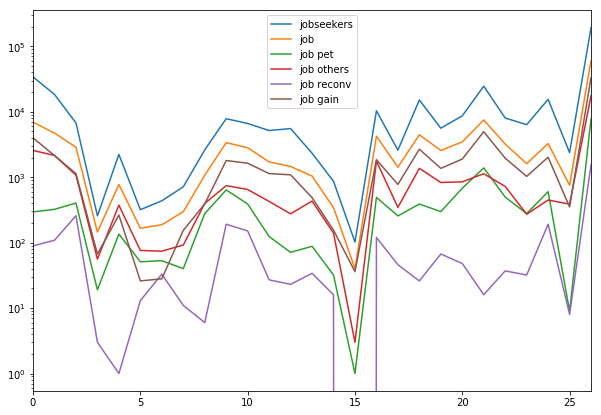

In [18]:
df = pd.read_csv(  "data/question2/purs chomeurs.csv", \
                   encoding = "UTF-16", \
                   skiprows = 4, \
                   index_col = None, \
                   header = None, \
                   names = ["Canton", "measures", "unemployment", "jobseekers", "job", "job pet", "job others", "job reconv", "job gain", "in", "out"], \
                )[["Canton", "jobseekers", "job", "job pet", "job others", "job reconv", "job gain"]]

for c in df.columns[1:]:
    df[c] = df[c].map(lambda x : ''.join(x.split("'"))).astype(float)

df.plot(kind='line', logy=True, figsize=(10, 7))
plt.show()

### (3)

(3) Use the [amstat](https://www.amstat.ch) website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between *Swiss* and *foreign* workers.

   The Economic Secretary (SECO) releases [a monthly report](https://www.seco.admin.ch/seco/fr/home/Arbeit/Arbeitslosenversicherung/arbeitslosenzahlen.html) on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for *foreign* (`5.1%`) and *Swiss* (`2.2%`) workers. 

   Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (*hint* The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?

   Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.




To show the difference between the swiss and the foreigner, we have decided to show on the map the ratio swiss unemployment rate / foreigner unemployment rate , so that we can compare every canton with eachother even if they have differences in population and unemployment rate.

 From amstat we got the unemployment rate of the swiss by canton by getting in 2 "unemployed and jobseeker" 2.1 "unemployment rate" with the following arguments :
1. "Selected period to review" : 
    Month under review
2. "unemployment rate indicator" : 
    unemployment rate
3. "unemployment indicator" : 
    None
4. "jobseeker indicator" : 
    None
5. "geographical structure" : 
    Canton
6. "Option : Restrain the data to one or more cantons" : None
7. "Other attributs" : Nationality 
 

In [19]:
# load the data about the unemployment rate by nationality from the csv file to a datframe
question3 = pd.read_csv("data/question3/swiss unemployment rate by nationality.csv", \
                        encoding = "UTF-16", \
                        skiprows = 2, \
                        index_col = None, \
                        header = None, \
                        names = ["Canton", "Nationality", "useless", "useless2", "Unemployed rate"], \
                       )[["Canton", "Nationality", "Unemployed rate"]]

# dataframe of the foreigner unemployment rate by canton
unemployedForeigner = question3[question3["Nationality"] == "Etrangers"][["Canton", "Unemployed rate"]]

# dataframe of the swiss unemployment rate by canton
unemployedSwiss = question3[question3["Nationality"] == "Suisses"][["Canton", "Unemployed rate"]]

# we merge the 2 dataframe so that for each line (meaning for each canton) we have both the unemployment rate for the 2 groups
question3 = unemployedForeigner.merge(  unemployedSwiss, \
                                        on = "Canton", \
                                        how = 'inner', \
                                        suffixes = [" for foreigner", " for swiss"])

# create a column that calulate the ratio swiss unemployment rate / foreigner unemployment rate
question3["ratio foreigner/swiss"] = question3["Unemployed rate for foreigner"] / question3["Unemployed rate for swiss"]
question3.head()

,Canton,Unemployed rate for foreigner,Unemployed rate for swiss,ratio foreigner/swiss
0,Zurich,5.3,2.5,2.120000
1,Berne,5.5,1.8,3.055556
2,Lucerne,3.9,1.3,3.000000
3,Uri,2.1,0.4,5.250000
4,Schwyz,3.4,1.2,2.833333


That map scale on a yellow to green color with 6 differents colours : the more yellow a canton is the less unemployment there is in it and the more green a canton is the more unemployment there is in it. We choose the colour Yellow green to fill the graph because it is quite easy on the eyes, we made it opaque enough so that we see the colour well but transparent enough so that we can still se through it.

We store this map in the file "question2" inside the file "html" as 'swiss ratio.html'.

In [20]:
# create a map of Switzerland, the location and the zoom is so as we are as close as possible while seeing all the canton
question3Map = folium.Map(location=[46.90, 8.5], zoom_start=8)

# fill the map with the coloured detail
question3Map.choropleth(geo_data = cantonsJson, \
                        data = question3, \
                        columns = ['Canton', 'ratio foreigner/swiss'], \
                        key_on = 'feature.properties.name', \
                        topojson = "objects.cantons", \
                        fill_color = 'YlGn', \
                        fill_opacity = 0.7, \
                        line_opacity = 0.2, \
                        legend_name = 'Unemployment Rate Ratio (Foreigner/Swiss)')

#save the html in a file
question3Map.save('html/question3/swiss ratio.html')


This resulting map can be seen [here](html/question3/swiss ratio.html).

Once again we seems to see the Röstigraben, compared to the swiss the foreigner from the french swiss have more qual chance to not be unemployed than in the deutsch part. We again see the Italian part be between those two. We can also see that the canton that have a lot of borders have more equity with jobs (at the exception of Grischun) compared to the one more inside the country.

The first reason we can find for this some part of Swiss are more discriminoritary than other but that would be too simple.

The second reason might be because of the borderer worker (non swiss peoples who come in Switzerland to works) : the idea of this explication is, if a borderer works in swiss it will count  asone more that will make a lower unemployment rate but if this borderer is unemployed because he is not in Switzerland, he will not be counted in their statistic as unemployed, so if we have a big enough pool of worker whose unemployment is not taken into account, we can begin to see some difference between the swiss and the foreigner. This could also explain why the deutsch part have such ratio because there is not that much difference in unemployment rate between Switzerland and Deutschland or Austria than between Switzerland and France or Italy (and maybe the italian prefer to ork in the italian part where they speak the same language).

The third reason is because of the very little unemployment rate of the deutsch part, any deviation, even little, causes the ratio to go up very fast, by example :  Uri have a ratio of 5 but a difference of unemployment of around 2 whereas the Jura has a ratio of 2.5 and a difference of 5 because its unemployment rate was very high from the beggining (but once again to see the difference of treatment for foreigners, a method that does not take into account that the unemployment rate were inequal from the beggining would make any comparaison less relevant).

 From amstat we got the unemployment rate of the swiss by canton by getting in "Jahredurchschnitte" "Arbeitslosen - und Jugendarbeitlosenquote nach verschieden Kriterien" with the following arguments :
1. "Jahr" : 
    2016
2. "Kenzhalen zur Arbeitslosenquote" : 
    unemployment rate
3. "Kenzhalen zur Arbeitslosigkeit" : 
    None
4. "geographical structure" : 
    Canton
5. "Merkamale zu Nationalt, Alter und Geschlecht" : 
    Alter and Nationality
6. "Option : Restrain the data to one or more cantons" : None

7. Merkamale des Alters : Age class 15-24, 25-49, 50 and more

We then download the csv of this database, and put it in the file data/question3 and name it "chomage_age_nationalite.csv".

Note : we could have taken the other attributes "Age class by step of 5 years" but there are missing value for this database and there would have been too much value to make the plot illisible, moreover the class showing the young, old worker and the rest is a very good way to analyse age classes.

In [21]:
question3AgeNation = pd.read_csv( "data/question3/chomage_age_nationalite.csv", \
                            encoding = "UTF-16", \
                            skiprows = 4, \
                            engine='python', \
                            skipfooter = 1, \
                            index_col = [0, 1, 3], \
                            header = None, \
                            names = ["canton", "nationalite", "taux", "age"]
                          )[["taux"]]


#change the taux column to float (without the ' in the column)
question3AgeNation['taux'] = question3AgeNation['taux'].map(lambda x : 0 if x == "..." else x).astype(float)



We now plot the the unemployment rate by canton and age class. We choose to plot it in a vertical way so that we have more place and we groupe the bar by canton so that we can examine easilly the difference by age class.

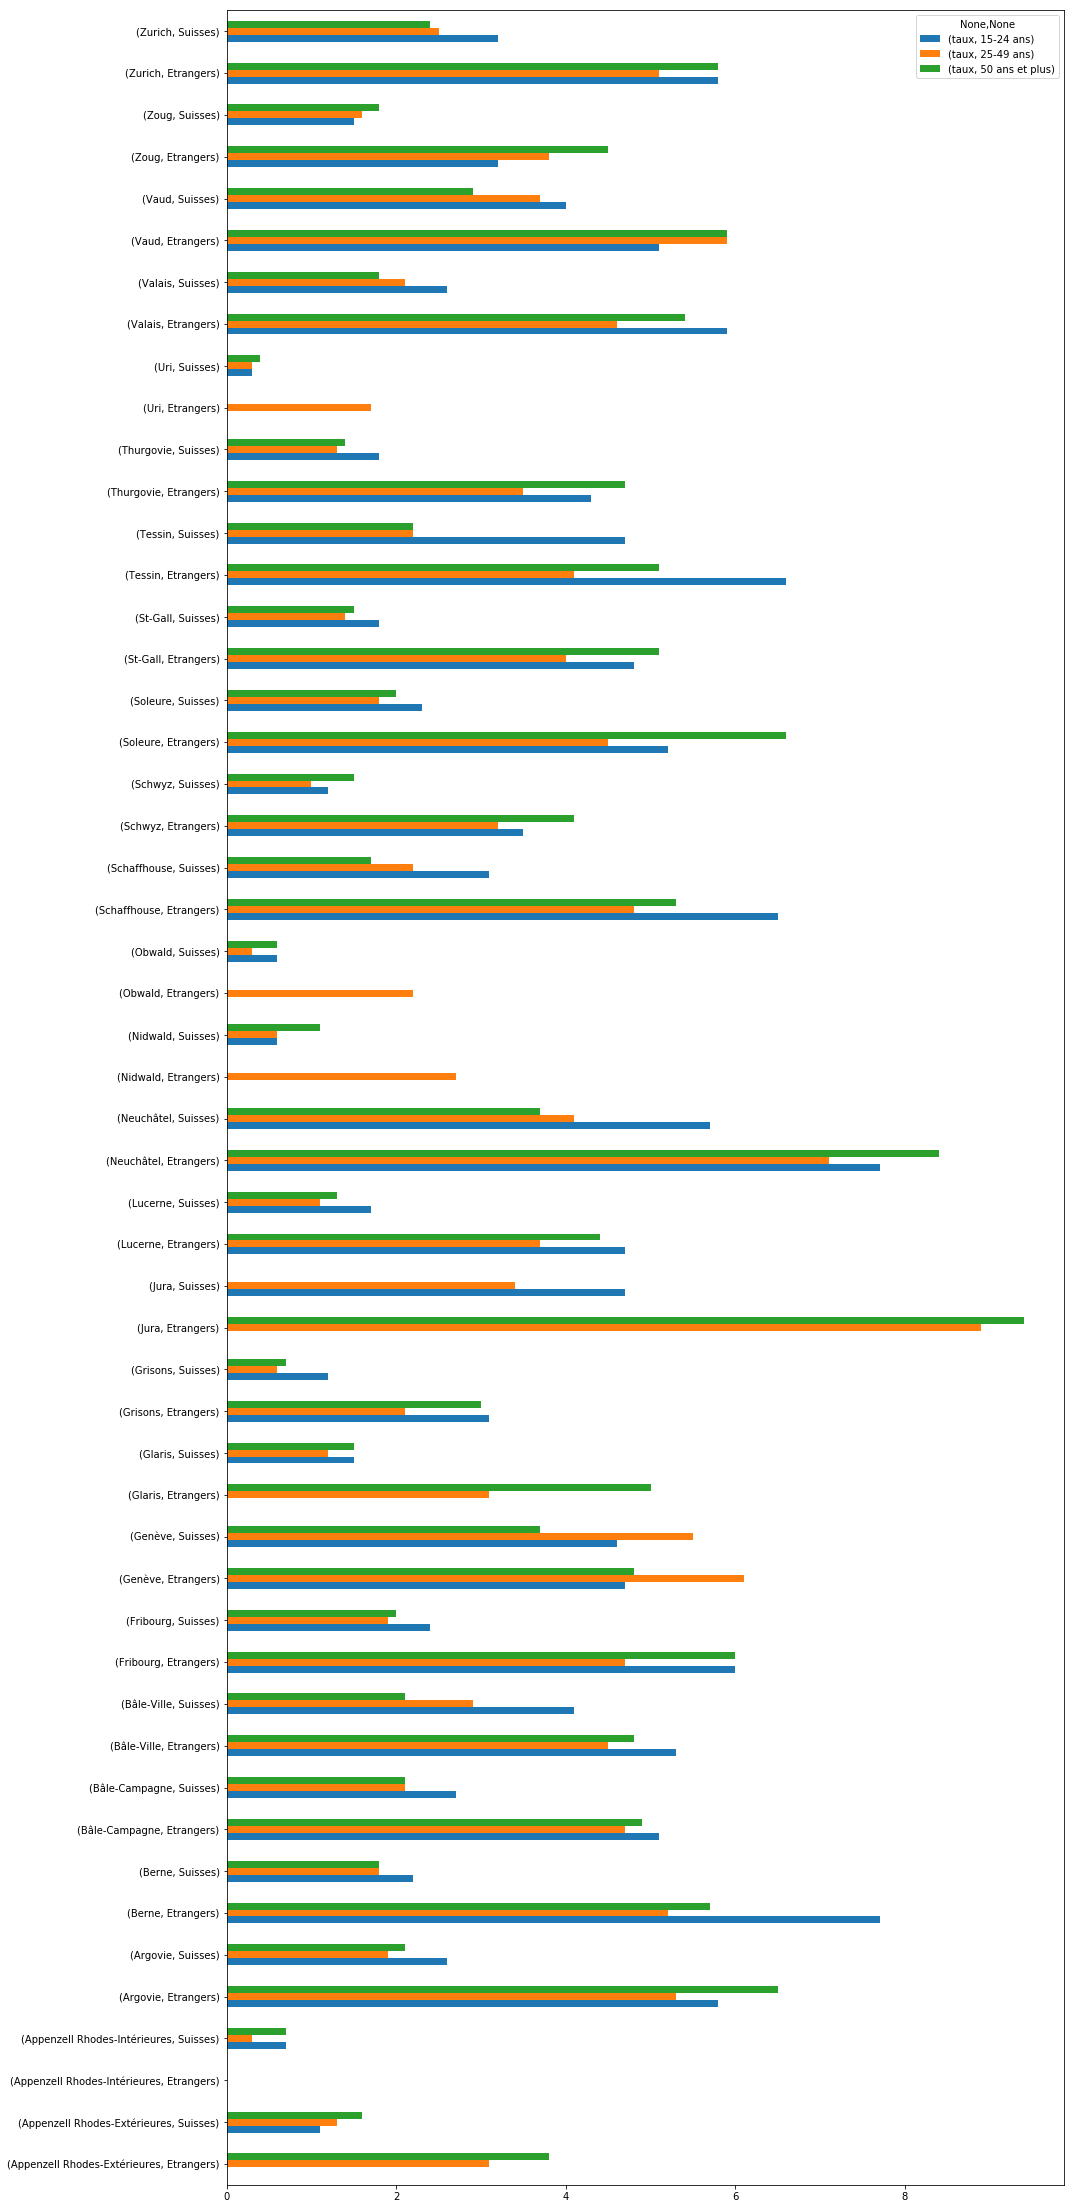

In [22]:
# give a number to the figure ( it is just for a good code practice)
plt.figure(101)
question3AgeNation.unstack().plot(kind='barh', figsize=[15, 40]).figure

### (4)

(4) *BONUS*: using the map you have just built, and the geographical information contained in it, could you give a *rough estimate* of the difference in unemployment rates between the areas divided by the [Röstigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben)?

Using the data used to create the first map (cantonUnemployment) we will calculate an approximation of the mean of the 2 geographical zone after having splitten the canton into the 2 categories as such :

-french : Jura , Neuchâtel , Genève, Vaud, Fribourg (because it is mostly french and it will compensate for Bern).

-None : Ticino (because it is italian) , Valais (because it is split in half as deutsch/french and we can not choose one part it should go to), Grisons (because it is too much split between bilingual, italian and romansch to be considered only deutsch)

-deutsch : the rest (included Bern because it is mostly deutsch and it will compensate for Fribourg)

In [23]:
#list of considered french caton
french = ['Jura', 'Neuchâtel', 'Genève', 'Vaud', 'Fribourg']
#list of canton considered neither french nor deutsch
none = ['Tessin', 'Valais' ,'Grisons' ]

#make a copy so that the original dataframe will not change
frenchUnemployment = cantonUnemployment.copy()

#The 2 next line will create a filter that will give only the french canton
#this line change the non french canton name to Nan
frenchUnemployment['Canton'] = frenchUnemployment['Canton'].map(lambda x : x if x in french else np.nan)
#delete the line with Nan (not french canton) and take out the unemployment column
frenchUnemployment=frenchUnemployment.dropna()['Unemployment']
#create the mean of the unemployment rates for the french canton
frenchMean = frenchUnemployment.sum() / frenchUnemployment.size


#make a copy so that the original dataframe will not change
deutschEmployment = cantonUnemployment.copy()

#The 2 next line will create a filter that will give only the deutsch canton
#this line change the non deutsch canton name to Nan
deutschEmployment['Canton'] = deutschEmployment['Canton'].map(lambda x : np.nan if x in french or x in none else x)
#delete the line with Nan (not deutsch canton) and take out the unemployment column
deutschEmployment=deutschEmployment.dropna()['Unemployment']
#create the mean of the unemployment rates for the fredeutschnch canton
deutschMean = deutschEmployment.sum() / deutschEmployment.size

frenchMean - deutschMean 

2.2400000000000007

So we have approximate the difference between french and deutsch unemployment to be 2.24% less for the deutsch part.